In [30]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime as dt

## Data Dictionary
1. TP2 (bar) – the measure of the pressure on the compressor.
2. TP3 (bar) – the measure of the pressure generated at the pneumatic panel.
3. H1 (bar) – the measure of the pressure generated due to pressure drop when the discharge of the cyclonic separator filter occurs.
4. DV pressure (bar) – the measure of the pressure drop generated when the towers discharge air dryers; a zero reading indicates that the compressor is operating under load.
5. Reservoirs (bar) – the measure of the downstream pressure of the reservoirs, which should be close to the pneumatic panel pressure (TP3).
6. Motor Current (A) –  the measure of the current of one phase of the three-phase motor; it presents values close to 0A - when it turns off, 4A - when working offloaded, 7A - when working under load, and 9A - when it starts working.
7. Oil Temperature (ºC) –  the measure of the oil temperature on the compressor.
8. COMP - the electrical signal of the air intake valve on the compressor; it is active when there is no air intake, indicating that the compressor is either turned off or operating in an offloaded state.
9. DV electric – the electrical signal that controls the compressor outlet valve; it is active when the compressor is functioning under load and inactive when the compressor is either off or operating in an offloaded state.
10. TOWERS – the electrical signal that defines the tower responsible for drying the air and the tower responsible for draining the humidity removed from the air; when not active, it indicates that tower one is functioning; when active, it indicates that tower two is in operation.
11. MPG – the electrical signal responsible for starting the compressor under load by activating the intake valve when the pressure in the air production unit (APU) falls below 8.2 bar; it activates the COMP sensor, which assumes the same behaviour as the MPG sensor.
12. LPS – the electrical signal that detects and activates when the pressure drops below 7 bars.
13. Pressure Switch - the electrical signal that detects the discharge in the air-drying towers.
14. Oil Level – the electrical signal that detects the oil level on the compressor; it is active when the oil is below the expected values.
15. Caudal Impulse – the electrical signal that counts the pulse outputs generated by the absolute amount of air flowing from the APU to the reservoirs.


In [2]:
df = pd.read_csv("../data/metroPtdata.csv")

In [3]:
df.head()

,id,timestamp,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses
0,0,2020-02-01 00:00:00,-0.012,9.358,9.340,-0.024,9.358,53.600,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
1,10,2020-02-01 00:00:10,-0.014,9.348,9.332,-0.022,9.348,53.675,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2,20,2020-02-01 00:00:19,-0.012,9.338,9.322,-0.022,9.338,53.600,0.0425,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
3,30,2020-02-01 00:00:29,-0.012,9.328,9.312,-0.022,9.328,53.425,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
4,40,2020-02-01 00:00:39,-0.012,9.318,9.302,-0.022,9.318,53.475,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0


## timestap
### Datatype: datetime

In [7]:
# first we look at the total date range in a simple way
print(f"The the first collection point is {df['timestamp'].min()}")
print(f"The the first collection point is {df['timestamp'].max()}")

The the first collection point is 2020-02-01 00:00:00
The the first collection point is 2020-09-01 03:59:50


so we have 7 months of data in this dataset. We can use the first month to demonstrate how the model trains, and the others to show how it changes over time

In [27]:
# we change the `timestamp` variable to a datetime so we can more easily manipulate it
print(df['timestamp'].dtype)
df['timestamp'] = pd.to_datetime(df['timestamp'])
print(df['timestamp'].dtype)

datetime64[ns]
datetime64[ns]


In [28]:
# then we create a date column,so we can look at the number of datapoints on a given day
df['date'] = df['timestamp'].dt.date

In [41]:
# we can plot it on a barchart to see the number of measurements per day
# first we create a function to visualize easily
def create_barchart(df):
  """Creates a barchart of the values in `df['date'].value_counts().sort_index()`.

  Args:
    df: A pandas DataFrame.

  Returns:
    A matplotlib figure.
  """

  # Get the values and counts from the DataFrame.
  values = df['date'].value_counts().sort_index()
  counts = values.values

  # Create a barchart.
  fig, ax = plt.subplots()
  ax.bar(values.index, counts)

  # Set the title and labels.
  plt.title('Date Counts')
  plt.xlabel('Date')
  plt.ylabel('Count')

  # Make it pretty.
  sns.set_style('ticks')
  plt.tight_layout()

  return fig

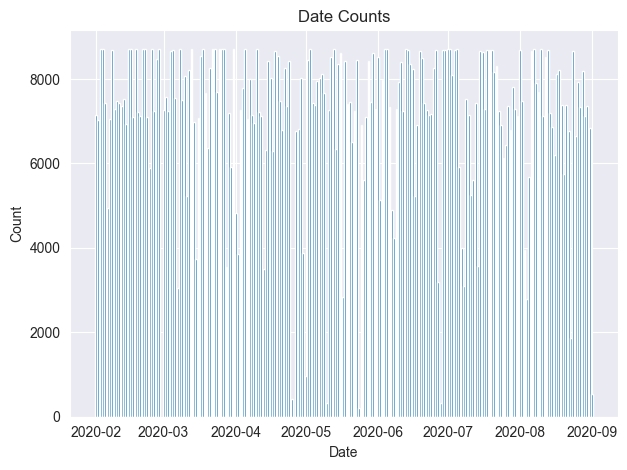

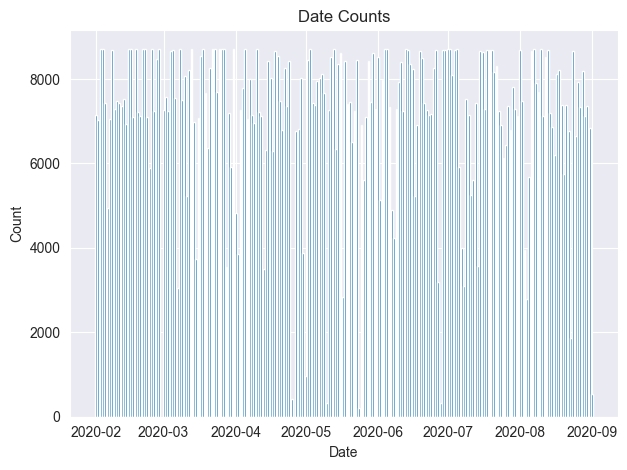

In [42]:
create_barchart(df)

From the chart above we can see a fairly uniform data collection process. Some things to note
1. There is some serious downtime in the month of March and the end of May and in the beginning of August
2. There are usually about 6-8,000 measurements done every single day
3. This looks like very normal for an embedded device monitoring tool

## Correlation Analysis

In [45]:
# first we create a function to easily visualize a correlation matrix
def create_correlation_plot(df):
  """Creates a correlation plot from a pandas DataFrame.

  Args:
    df: A pandas DataFrame.

  Returns:
    A matplotlib Axes object with the correlation plot.
  """

  import matplotlib.pyplot as plt
  import seaborn as sns

  # Create a figure and axes object
  fig, ax = plt.subplots()

  # Plot the correlation plot
  sns.heatmap(df.corr(), ax=ax, annot=True, fmt='.2f', cmap='coolwarm')

  # Set the title and labels
  ax.set_title('Correlation Plot')
  ax.set_xlabel('Column')
  ax.set_ylabel('Row')

  # Return the axes object
  return ax

<Axes: title={'center': 'Correlation Plot'}, xlabel='Column', ylabel='Row'>

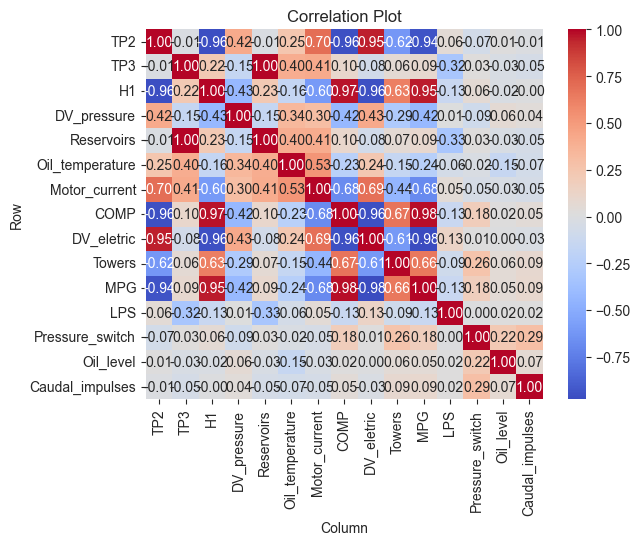

In [49]:
create_correlation_plot(df.iloc[0:,2:-1])

In [103]:
def correlation_rank(df):
    """
    This function calculates the correlation rank of all features in a DataFrame.

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame containing the data to be correlated.

    Returns
    -------
    pandas.DataFrame
        A DataFrame containing the correlation rank of each feature.
    """
    corr_df = df.corr().reset_index()
    corr_df_melt = pd.melt(corr_df,id_vars='index',value_vars=corr_df.columns).sort_values('value')
    final_df = corr_df_melt[corr_df_melt['value']!=1].sort_values('value',ascending=False)
    final_df = final_df[~final_df.apply(frozenset, axis=1).duplicated()]
    return final_df

In [104]:
corr_rank = correlation_rank(df.iloc[0:,2:-1])

In [107]:
# print out the corr ranking for easy analysis. This is the same values as the ones in
# the heatmap
corr_rank.sort_values('value', ascending= False)

,index,variable,value
19,Reservoirs,TP3,0.999993
115,MPG,COMP,0.984555
107,H1,COMP,0.971419
40,MPG,H1,0.954307
120,TP2,DV_eletric,0.947396
...,...,...,...
7,COMP,TP2,-0.955521
122,H1,DV_eletric,-0.958663
113,DV_eletric,COMP,-0.959307
2,H1,TP2,-0.961269


From the dataframe above we can see a few important takeaways
1. Reservoirs, TP3, MPG, COMP, H1, TP2, DV_electric are all highly correlated.
2. Correlation drops tremendously from ~.0.90 to ~0.68 which indicates the high correlation variables may be measuring similar effects in a different way
3. Towers, Oil Level, and Caudal Impulses are not highly correlated with any other sensor;

## Time Series Analysis

array([[<Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'timestamp'}>,
        <Axes: title={'center': 'TP2'}>, <Axes: title={'center': 'TP3'}>],
       [<Axes: title={'center': 'H1'}>,
        <Axes: title={'center': 'DV_pressure'}>,
        <Axes: title={'center': 'Reservoirs'}>,
        <Axes: title={'center': 'Oil_temperature'}>],
       [<Axes: title={'center': 'Motor_current'}>,
        <Axes: title={'center': 'COMP'}>,
        <Axes: title={'center': 'DV_eletric'}>,
        <Axes: title={'center': 'Towers'}>],
       [<Axes: title={'center': 'MPG'}>, <Axes: title={'center': 'LPS'}>,
        <Axes: title={'center': 'Pressure_switch'}>,
        <Axes: title={'center': 'Oil_level'}>],
       [<Axes: title={'center': 'Caudal_impulses'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

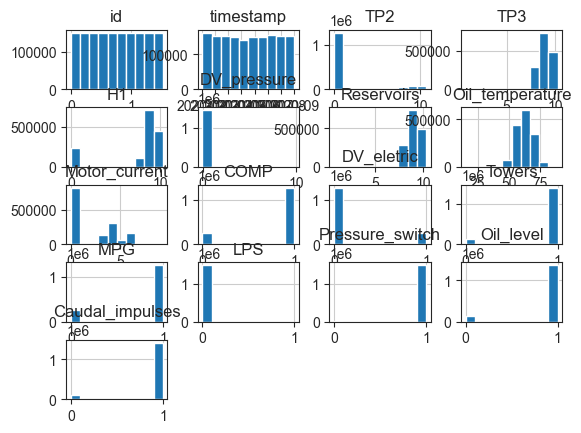

In [112]:
# quick check for distribution
df.hist()

In [ ]:
#look at each column in relation to time

### Dickey Fuller Test

In [109]:
import statsmodels.tsa.stattools as stattools
df.head()


,id,timestamp,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,date
0,0,2020-02-01 00:00:00,-0.012,9.358,9.340,-0.024,9.358,53.600,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,2020-02-01
1,10,2020-02-01 00:00:10,-0.014,9.348,9.332,-0.022,9.348,53.675,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,2020-02-01
2,20,2020-02-01 00:00:19,-0.012,9.338,9.322,-0.022,9.338,53.600,0.0425,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,2020-02-01
3,30,2020-02-01 00:00:29,-0.012,9.328,9.312,-0.022,9.328,53.425,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,2020-02-01
4,40,2020-02-01 00:00:39,-0.012,9.318,9.302,-0.022,9.318,53.475,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,2020-02-01


In [ ]:
adf_results = stattools.adfuller()